In [1]:
import pandas as pd
import py0
import maxent
from py0 import MetaModel, traj_quantile, patch_quantile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Set-up Model Parameters

In [2]:
# load mobility matrix
data = pd.read_csv('nys_commuting_counties.csv', index_col = 0).values
data = [i / np.sum(i) for i in data]
R = np.array(data)
M = R.shape[0]
np.sum(R, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [3]:
# Make up some populations (take as known)
population = np.maximum(1000, np.round(np.random.normal(loc=100000, scale=25000, size=(M,)), 0))
area = np.maximum(250, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
print(area, population)


[ 250. 3063. 2264. 1296. 2186. 1093. 2294. 2085.  840. 1688.  548. 3076.
 1805. 2066.  980. 3625. 2697. 3234. 1018. 1922. 2076. 1266. 1580. 1984.
 1454.  250. 1358. 2603. 2313. 1584. 2695. 2090. 2679. 2873. 1713.  250.
 4037.  712. 4305. 2862. 3397. 1849. 1172. 2860. 1103.  799. 1779. 1771.
 1874. 2343. 3769. 3424. 1337. 3822. 2856.  939. 2084. 1656. 2229. 3328.
 3108. 3143.] [110999. 133072. 111677.  84771.  66929. 113671. 173343. 136336.  58394.
  72688. 110137.  94014.  74508. 121038. 111837.  95554.  62241. 100819.
 111886.  96048. 128131. 109072. 130214. 108845. 139144. 129095.  98840.
  93797.  86174. 105372.  62152.  95869.  67369.  60642.  93215.  77492.
  80984.  94376.  77166. 104485. 113465. 107092. 109841. 119525.  99400.
  74420. 142321. 115435. 120925. 110813.  68883. 159955. 155674. 110829.
 136441.  93381. 114681.  88522. 102711. 129604. 153191.  77170.]


In [4]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = py0.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 5, 5)
tmat.add_transition('A', 'I', 3, 2)
tmat.add_transition('I', 'R', 14, 6)
print(tmat.value)
np.sum(tmat.value, axis=1)

[[0.8        0.2        0.         0.        ]
 [0.         0.66666667 0.33333333 0.        ]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]


array([1., 1., 1., 1.])

In [5]:
# starting fractions probabilities
start = np.zeros((M,))  #anywhere
start[0] = 0.0001 # but likely 0

## Make starting joint

In [6]:
hyper_pram = py0.ParameterHypers()
hyper_pram.beta_low = [0.005]*2
hyper_pram.beta_high = [0.04]*2
hyper_pram.beta_var = [0.1]*2
param_model = py0.MetaParameterJoint(start, R, tmat, name='unbiased', n_infectious_compartments=2, hypers = hyper_pram)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


## Examine some of the statistics

In [7]:
v = param_model.sample(100)

/home/mgholiza/.conda/envs/covid-19/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


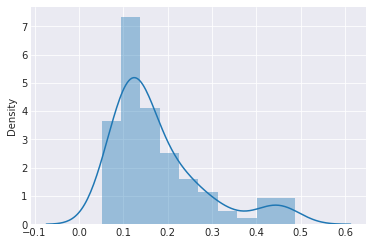

In [8]:
x = v[1][:,compartments.index('E'), compartments.index('A')].numpy()
sns.distplot(x=x)
plt.show()

In [9]:
np.mean(v[1][:, 0, 1]), 1/5

(0.17707995, 0.2)

In [10]:
# v[2][2]

In [11]:
# check transition matrix is valud
T = v[1][0].numpy()
print(T)
f = [0.1,0,0,0]
for i in range(1000):
    f = f @ T
    if i % 100 == 0:
        print(f, np.sum(f))

[[0.91796976 0.08203021 0.         0.        ]
 [0.         0.7900124  0.2099876  0.        ]
 [0.         0.         0.9158109  0.0841891 ]
 [0.         0.         0.         1.        ]]
[0.09179698 0.00820302 0.         0.        ] 0.09999999776482583
[1.76062154e-05 1.12868961e-05 2.17503792e-04 9.97535653e-02] 0.09999996219476774
[3.37678683e-09 2.16477256e-09 7.71381141e-08 9.99998795e-02] 0.09999996214842446
[6.47651357e-13 4.15192892e-13 2.01632094e-11 9.99999621e-02] 0.09999996214840921
[1.24216393e-16 7.96319855e-17 4.68084609e-15 9.99999621e-02] 0.0999999621484092
[2.38241025e-20 1.52730291e-20 1.02107761e-18 9.99999621e-02] 0.09999996214840909
[4.56934746e-24 2.92929300e-24 2.14527014e-22 9.99999621e-02] 0.09999996214840909
[8.76378709e-28 5.61824207e-28 4.39777586e-26 9.99999621e-02] 0.09999996214840909
[1.68085191e-31 1.07755162e-31 8.86401274e-30 9.99999621e-02] 0.09999996214840909
[3.22379255e-35 2.06669180e-35 1.76513746e-33 9.99999621e-02] 0.09999996214840909



## Create set of trajectories
The loop is just to batch the trajectories. It is not necessary, just I have my at home GPU which has small RAM.
You could instead just pick `N = 16 * 256` and call once.

In [12]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 256
batches = 4
total_batches = N*batches
outs = []
timesteps = 360
infect_fxn = py0.contact_infection_func(infections_compartments, area=area)
model = MetaModel(infect_fxn, timesteps, populations=population)
for b in tqdm.tqdm(range(batches)):
    psample = param_model.sample(N)
    outs.append(model(*psample))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|██████████| 4/4 [00:20<00:00,  5.06s/it]

(1024, 360, 62, 5)


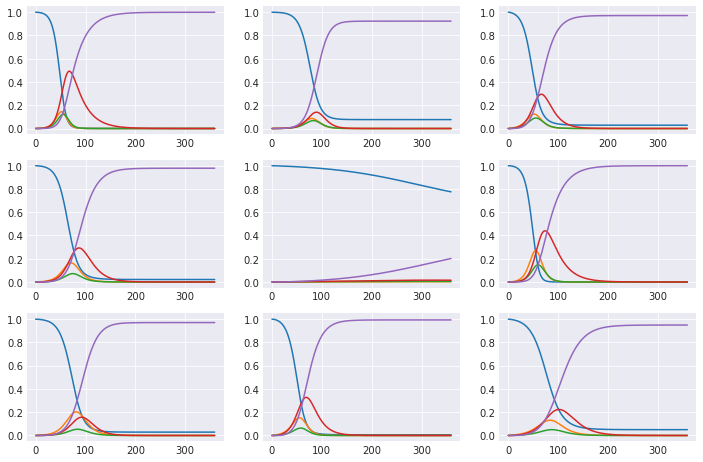

In [13]:
# plot a few trajectories
fig, ax = plt.subplots(3, 3, figsize=(12,8))
for i in range(3):
    for j in range(3):
        ax[i,j].plot(trajs[i * 3 + j,:,0,:])
plt.show()

## Make quantile Plots

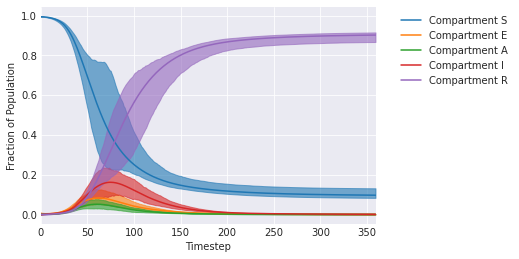

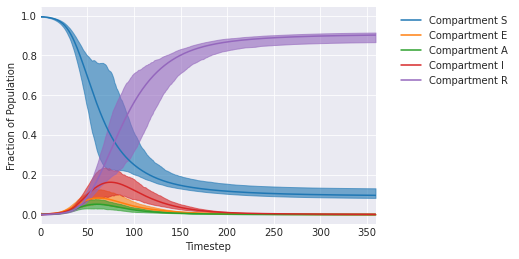

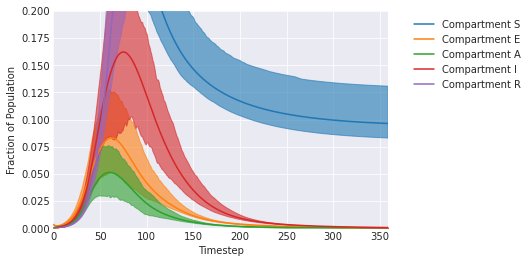

In [14]:
full_compartments = ['S'] + compartments
traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.show()
traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True)
plt.show()
traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True)
plt.ylim(0,0.2)
plt.show()

## Create arbitrary restraints

In [15]:
restraints = np.array([
    [0.4, 0, 250, 0, 0],
    [0.12,0.05,200,2,1],
    [0.8, 0.1,300, 1, 4],
    [0.6, 0.1, 250, 34, 4],
    [0.4, 0.1, 250, 24, 0],
             ])
laplace_restraints = []
for i in range(len(restraints)):
    traj_index = tuple(restraints[i, 2:].astype(np.int))
    value = restraints[i, 0]
    uncertainty = restraints[i, 1]
    p = maxent.Laplace(uncertainty)
    #p = maxent.EmptyPrior()
    r = maxent.Restraint(lambda traj,j=traj_index: traj[j], value, p)
    laplace_restraints.append(r)

## Use maxent model to fit

In [26]:
model = maxent.MaxentModel(laplace_restraints)
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

In [27]:
history = model.fit(trajs, batch_size=total_batches, epochs=500, verbose=0)

In [28]:
model.summary()

Model: "maxent-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reweight_layer_laplace_3 (Re multiple                  5         
_________________________________________________________________
avg_layer_laplace_3 (AvgLaye multiple                  5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


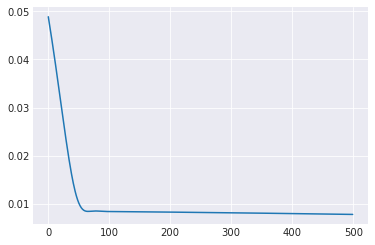

In [29]:
plt.plot(history.history['loss'])

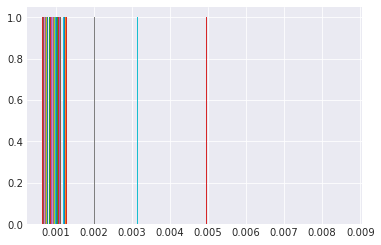

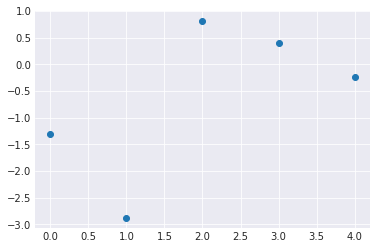

In [30]:
weights = model.traj_weights
plt.hist(weights)
plt.show()
plt.plot(model.lambdas.numpy(), 'o')

## Complete patch plots
disable if you want, they are very slow

Plotting 62 patches in a 7 x 9 grid


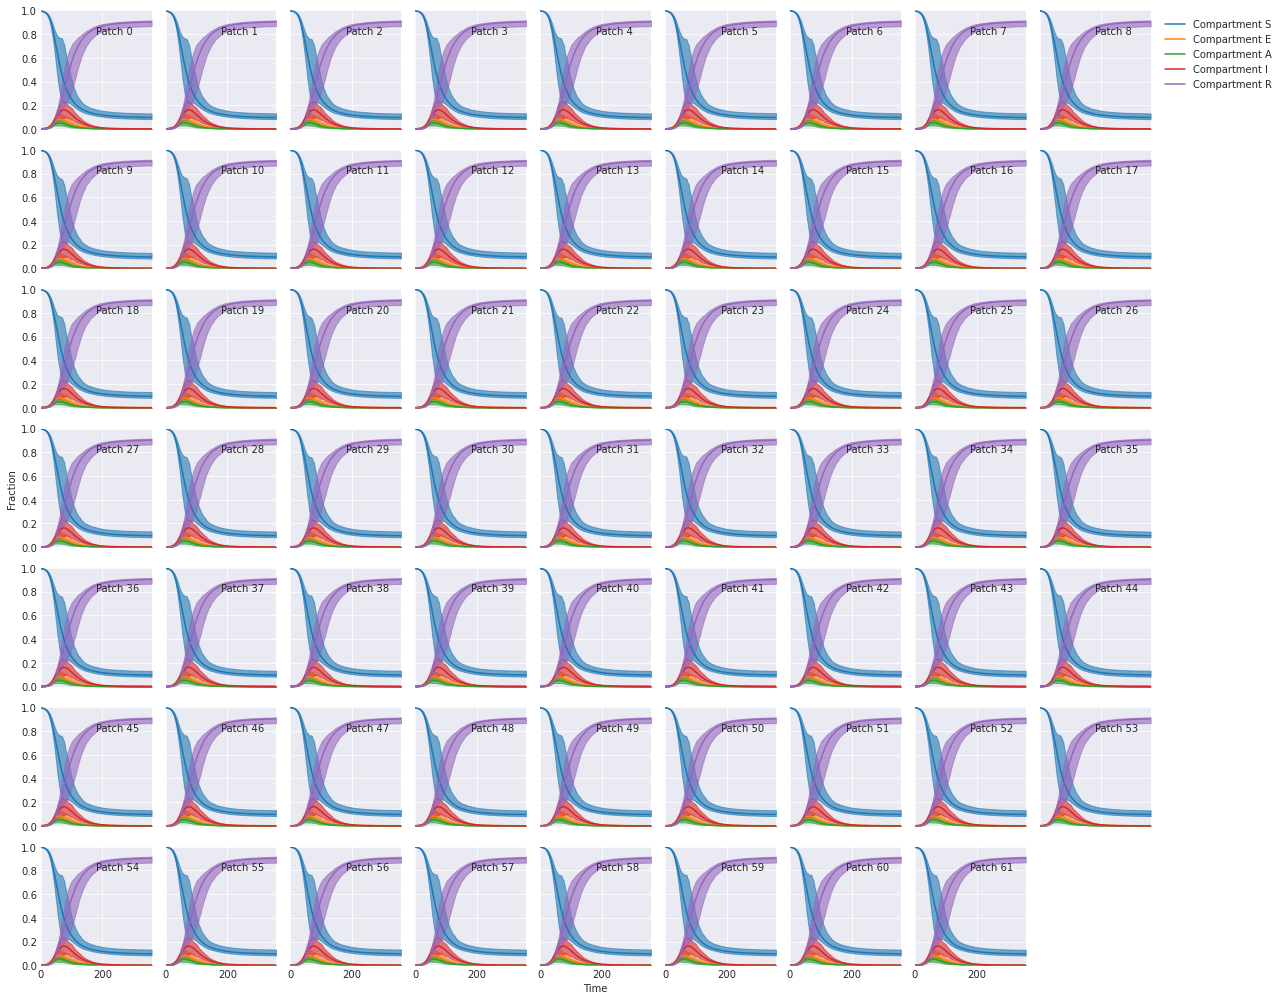

In [31]:
patch_quantile(trajs, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
plt.show()

Plotting 62 patches in a 7 x 9 grid


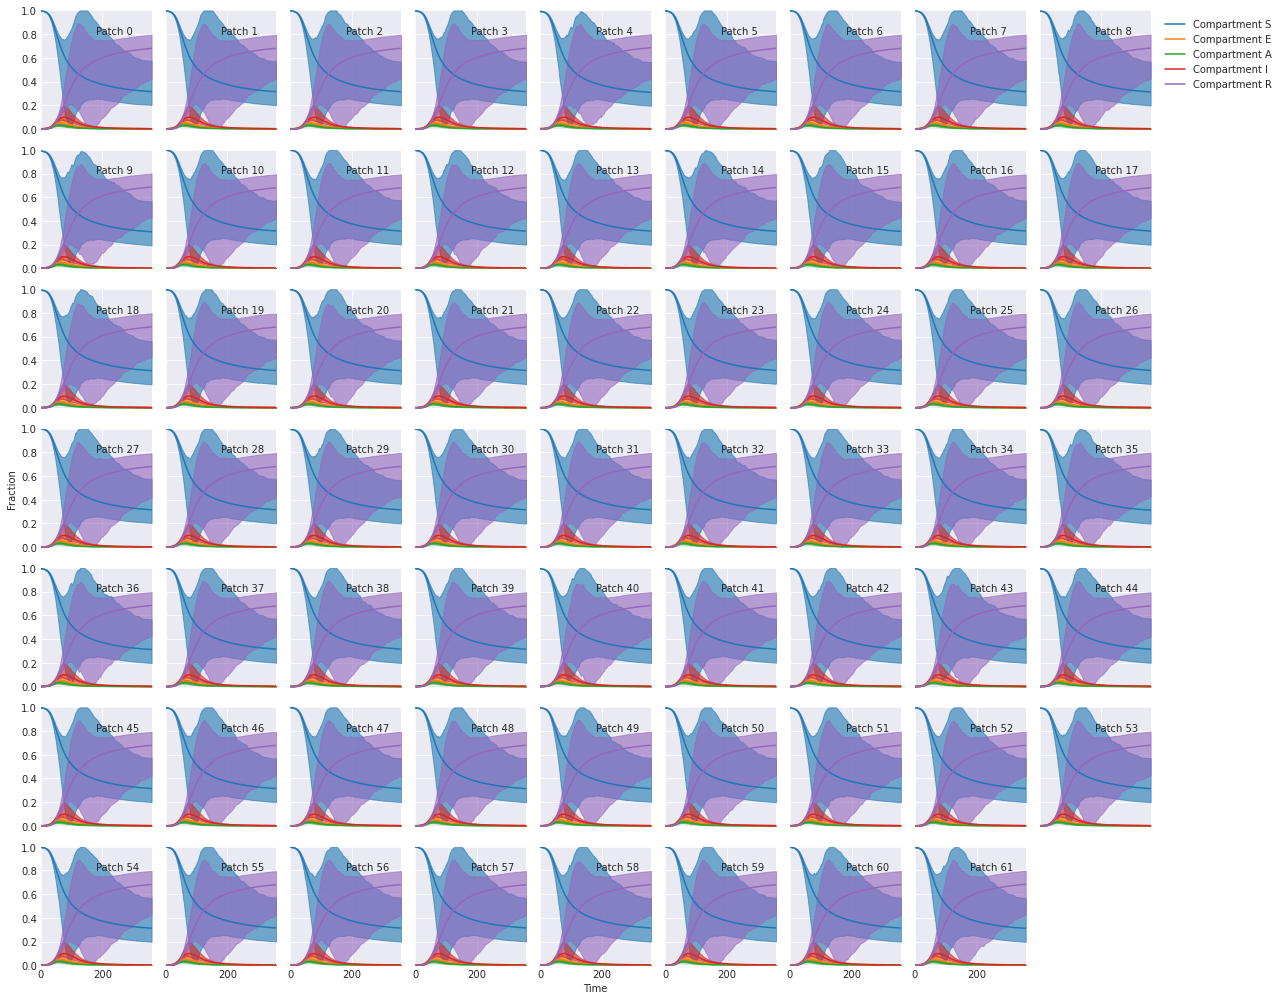

In [32]:
patch_quantile(trajs, weights=weights, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
plt.show()

## Final plots showing agreement

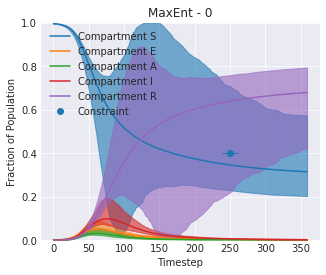

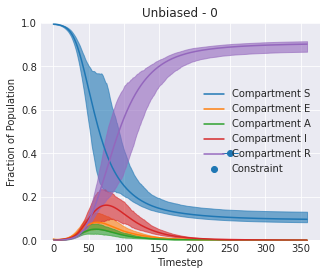

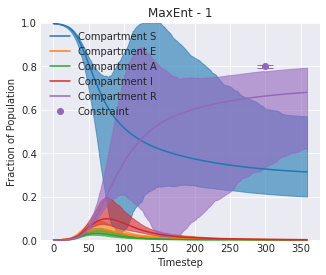

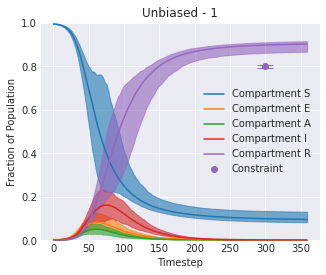

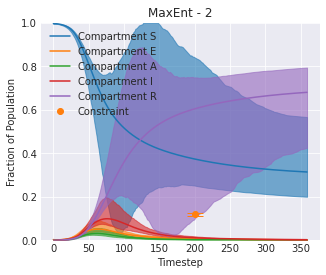

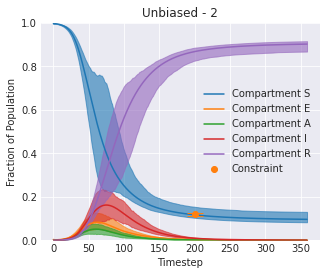

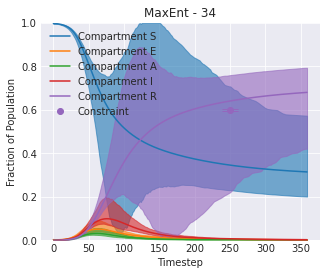

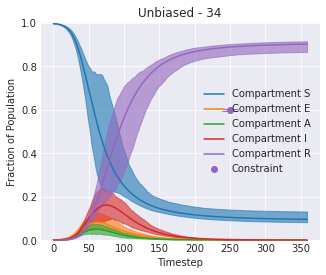

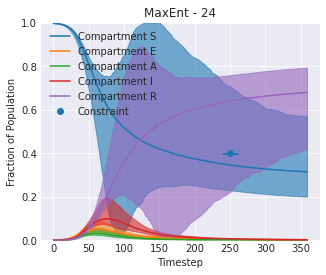

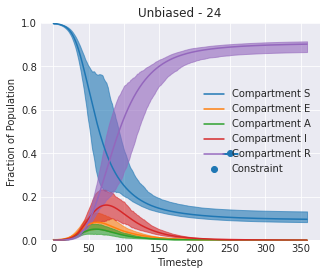

In [33]:
for p in [0,1,2,34,24]:
    plt.figure(figsize=(5,4))
    plt.title(f'MaxEnt - {p}')
    traj_quantile(trajs[:,:,p,:], weights, add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(float(model.lambdas[i])), color=f'C{int(r[-1])}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()
    plt.figure(figsize=(5,4))
    plt.title(f'Unbiased - {p}')
    traj_quantile(trajs[:,:,p,:], add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(float(model.lambdas[i])), color=f'C{int(r[-1])}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()